# Random Forest Depth Feature Selection Algorithm

[Classifying the multi-omics data of gastric cancer using a deep feature selection method](https://www.sciencedirect.com/science/article/pii/S0957417422002706?casa_token=uxRroo-x9HQAAAAA:gX9NO27PzokyWoVNC2XL3FNGjhHUqO3MB7c5XhXbD9wk9DHrK3qn8p8Z2dOBA0uWQguDzWjv4lxM)

The algorithm has two core parts. The first part uses a random forest to select the important feature genes from the multi-omics data, and the second part uses a neural network to train the selected genes and classify them.

### 1. Random forest feature selection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import shap
import pandas as pd
from keras.src.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import seaborn as sns
from helper import *
from sklearn.model_selection import GridSearchCV
from feature_selection import venn_diagram
# Supress all warnings
import warnings
from sklearn.preprocessing import StandardScaler
import lime
import lime.lime_tabular
from matplotlib.patches import Patch
from sklearn.ensemble import RandomForestClassifier
from keras.src.layers import Dropout
from keras.src.regularizers import l1_l2
from interpret.glassbox import ExplainableBoostingClassifier
from helper import *
from sklearn.metrics import roc_auc_score
from interpret import show
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression

In [2]:
path = "C:/Users/mjgoj/Desktop/THESIS/data/final_dataset_split.xlsx"
xls = pd.ExcelFile(path)

lipidomics = pd.read_excel(xls, "Lipidomics")
metabolomics = pd.read_excel(xls, "Pareto Metabolomics")
proteomics = pd.read_excel(xls, "Pareto Proteomics")

# Load the binary dataset
X_train, X_test, Y_train, y_test = concatenate_data(
    lipidomics, metabolomics, proteomics, num_classes=2)

Training set shape:  (58, 1118)
Testing set shape:  (38, 1118)


In [3]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

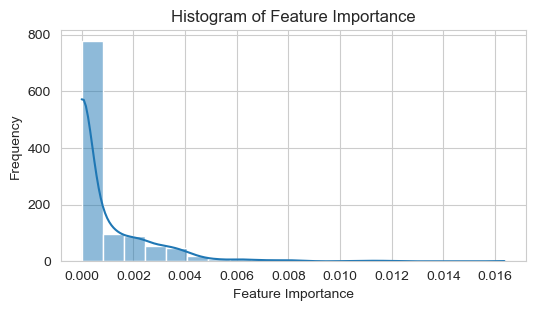

In [4]:
# Plot histogram of feature importance  
plt.figure(figsize=(6, 3))
sns.histplot(rf.feature_importances_, bins=20, kde=True)
plt.xlabel("Feature Importance")
plt.ylabel("Frequency")
plt.title("Histogram of Feature Importance")
plt.show()

In [5]:
feature_importance = pd.DataFrame(
    [rf.feature_importances_, X_train.columns], index=["Importance", "Feature"]).T
# Add the omics data type to the feature importance dataframe
feature_importance["Omics"] = None
for i, feature in enumerate(feature_importance["Feature"]):
    if feature in lipidomics.columns:
        feature_importance.loc[i, "Omics"] = "Lipidomics"
    elif feature in metabolomics.columns:
        feature_importance.loc[i, "Omics"] = "Metabolomics"
    elif feature in proteomics.columns:
        feature_importance.loc[i, "Omics"] = "Proteomics"

# Sort the features based on importance
feature_importance = feature_importance.sort_values(
    by="Importance", ascending=False).reset_index(drop=True)
print(np.unique(feature_importance["Omics"], return_counts=True))

(array(['Lipidomics', 'Metabolomics', 'Proteomics'], dtype=object), array([578, 213, 320], dtype=int64))


In [6]:
def plot_feature_importance(df, n=10):
    plt.figure(figsize=(6, 5))
    sns.barplot(x="Importance", y="Feature", data=df.head(n), hue="Omics", palette="husl")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Top {} Feature Importance".format(n))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

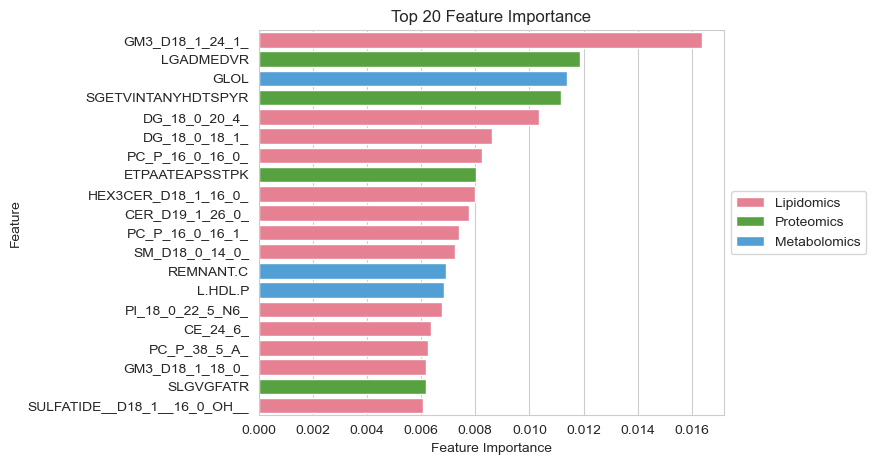

In [7]:
plot_feature_importance(feature_importance, n=20)

In [8]:
NUM_FEATURES = 50

In [9]:
rf_features = feature_importance["Feature"][0:NUM_FEATURES]

# Compare to the feature set from l1 logistic regression
l1_features = []
with open('selected_features.txt', 'r') as f:
    for line in f:
        l1_features.append(line.strip())

print("Common features between RF and L1: ", len(
    set(rf_features).intersection(set(l1_features))))

print(type(rf_features))
print(type(l1_features))

Common features between RF and L1:  18
<class 'pandas.core.series.Series'>
<class 'list'>


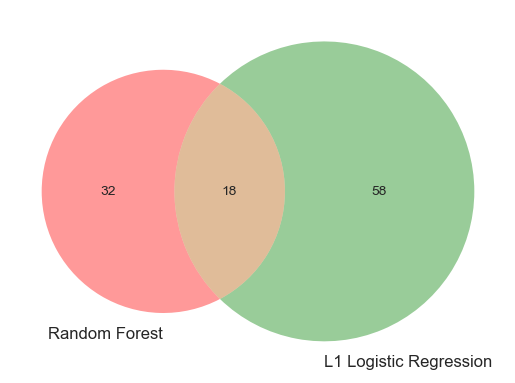

In [10]:
venn_diagram([set(rf_features), set(l1_features)], ("Random Forest", "L1 Logistic Regression"))

In [11]:
X_train_rf = X_train[rf_features]
X_test_rf = X_test[rf_features]

In [14]:
mapping = {1: 0, 2: 1}
if 2 in np.unique(Y_train):
    Y_train = Y_train.map(mapping)
    y_test = y_test.map(mapping)
    print(Y_train)

3     1
5     1
7     1
8     1
12    1
13    1
17    1
20    1
21    1
23    1
24    1
26    1
27    1
28    1
29    1
31    1
32    1
36    1
40    1
41    1
42    1
44    1
45    1
46    1
47    1
48    1
50    1
51    1
52    1
54    1
55    1
56    1
57    1
58    1
59    1
60    1
61    1
63    1
65    1
66    1
70    0
71    0
72    0
74    0
77    0
81    0
82    0
84    0
85    0
86    0
87    0
88    0
90    0
91    0
92    0
93    0
94    0
95    0
Name: TwoClass, dtype: int64


### 2. EBM (Explainable Boosting Machine)

[InterpretML: A Unified Framework for Machine Learning Interpretability](https://arxiv.org/pdf/1909.09223.pdf)

In [15]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, Y_train)

auc = roc_auc_score(y_test, ebm.predict_proba(X_test)[:, 1])
print("AUC: {:.3f}".format(auc))

AUC: 0.732


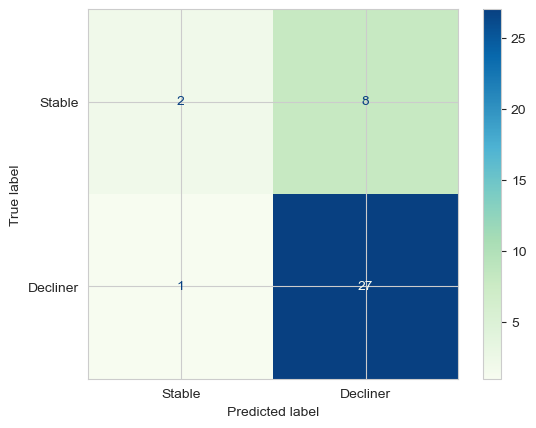

In [17]:
Y_pred = ebm.predict(X_test)
plot_confusion_matrix(y_test, Y_pred)

In [16]:
show(ebm.explain_global())

<!-- http://127.0.0.1:7001/2025489921232/ -->

### 3. (Failed) Neural Network

In [ ]:
from sklearn.utils import class_weight

hidden_units=70
learning_rate=0.1
hidden_layer_act='relu'
output_layer_act='sigmoid'
no_epochs=100
metrics='accuracy'

class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(Y_train), y=Y_train
)
class_weights = {0: class_weights[0], 1: class_weights[1]}
print(class_weights)

In [ ]:
from keras.src.optimizers import Adam

model = Sequential()

model.add(Dense(
    hidden_units, input_dim=X_test_rf.shape[1], 
    activation=hidden_layer_act, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))
)
model.add(Dropout(0.5))
model.add(Dense(
    hidden_units, activation=hidden_layer_act,
    kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation=output_layer_act))

# Set the learning rate in the optimizer
adam_optimizer = Adam(learning_rate=learning_rate)

model.compile(
    optimizer=adam_optimizer, 
    loss='binary_crossentropy',
    metrics=[metrics]
)

In [ ]:
history = model.fit(
    X_train_rf, Y_train, 
    epochs=no_epochs, batch_size=32, 
    class_weight=class_weights, validation_split=0.2,
    callbacks=[EarlyStopping(monitor='loss', patience=10)], verbose=1)

In [ ]:
# Plot the training accuracy
plt.figure(figsize=(6, 3))
plt.plot(model.history.history['accuracy'])  
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.show()

In [ ]:
# Plot the training loss
plt.figure(figsize=(6, 3))
plt.plot(model.history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [ ]:
# Evaluate the model
Y_pred = model.predict(X_test_rf)
print(Y_pred)
Y_pred = [0 if x < 0.5 else 1 for x in Y_pred]

accuracy = accuracy_score(y_test, Y_pred)
precision = precision_score(y_test, Y_pred)
recall = recall_score(y_test, Y_pred)
f1 = f1_score(y_test, Y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
# print(Y_pred)
plot_confusion_matrix(y_test, Y_pred)